<a href="https://colab.research.google.com/github/aarushkachhawa/Deep-Fake-Detection/blob/main/DeepFakeDetection%5BGit%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/data/archive.zip > /dev/null


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
from skimage.io import imread
from skimage.color import convert_colorspace
from skimage import exposure
from skimage import feature
from skimage.color import rgb2gray
from skimage.transform import resize
import pandas as pd
import tensorflow as tf
import torch
from numba import cuda 
import time

from tensorflow import keras

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import os
import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from keras import callbacks
import keras
from keras import losses
import gc
torch.manual_seed(111)

In [14]:
"""def preProcess(image):
    imgNewSpace = convert_colorspace(image, 'RGB', 'YCbCr')
    gammaEnhanced = exposure.adjust_gamma(imgNewSpace, 2)
    enhanced = convert_colorspace(gammaEnhanced, 'YCbCr','RGB')
    grayimg = rgb2gray(enhanced)
    edges = feature.canny(grayimg, sigma=3)
    return grayimg""" 


"def preProcess(image):\n    imgNewSpace = convert_colorspace(image, 'RGB', 'YCbCr')\n    gammaEnhanced = exposure.adjust_gamma(imgNewSpace, 2)\n    enhanced = convert_colorspace(gammaEnhanced, 'YCbCr','RGB')\n    grayimg = rgb2gray(enhanced)\n    edges = feature.canny(grayimg, sigma=3)\n    return grayimg"

In [15]:
from PIL import Image
image = Image.open('/content/real_vs_fake/real-vs-fake/test/real/00001.jpg')
image.size


(256, 256)

In [16]:
os.listdir('real_sample/')

FileNotFoundError: ignored

In [17]:
maxnum = 200
def loadImages(dataPath, category):
  flat_data_arr=[] #input array
  target_arr=[] #output array
  for i in range(len(dataPath)):
    for image in os.listdir(dataPath[i])[:maxnum]:
      if (not image.endswith('.jpg')):
        continue
      image_array = cv2.imread(os.path.join(dataPath[i], image))
      if image_array is None:
        print(image)
      #print(image_array.shape)
      image_resized = resize(image_array, (128,128,3))
      #image_preprocess = preProcess(image_resized)
      flat_data_arr.append(image_resized)
      target_arr.append(category[i])
      x = np.array(flat_data_arr)
      y = np.array(target_arr)
  return x, y

In [18]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [19]:
categories=[1,0] # [real, fake]

#path which contains all the categories of images
datadir='real_sample/'
datadirs = ['/content/real_vs_fake/real-vs-fake/test/real', '/content/real_vs_fake/real-vs-fake/test/fake'] 

x,y = loadImages(datadirs, categories)

In [20]:
x.shape

(400, 128, 128, 3)

In [21]:
x = np.resize(x, (x.shape[0], 128,128,3))
x.shape

#why da fuk is it 150x150x3 ?!?!

(400, 128, 128, 3)

In [22]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print('Splitted Successfully')
#x_train

Splitted Successfully


In [23]:
x_train

array([[[[0.01470588, 0.03137255, 0.05      ],
         [0.00588235, 0.02647059, 0.04607843],
         [0.00392157, 0.0254902 , 0.04509804],
         ...,
         [0.00196078, 0.03333333, 0.08235294],
         [0.00098039, 0.03235294, 0.08137255],
         [0.0127451 , 0.04411765, 0.09313725]],

        [[0.00980392, 0.0254902 , 0.04509804],
         [0.00784314, 0.0245098 , 0.04411765],
         [0.00196078, 0.02254902, 0.04215686],
         ...,
         [0.00098039, 0.03235294, 0.0745098 ],
         [0.        , 0.03137255, 0.07156863],
         [0.        , 0.03235294, 0.07254902]],

        [[0.00882353, 0.0245098 , 0.04411765],
         [0.00392157, 0.01960784, 0.03921569],
         [0.00392157, 0.02156863, 0.04215686],
         ...,
         [0.00588235, 0.03137255, 0.07156863],
         [0.00294118, 0.02843137, 0.06960784],
         [0.00392157, 0.03137255, 0.06666667]],

        ...,

        [[0.01176471, 0.03235294, 0.04411765],
         [0.00980392, 0.03039216, 0.04117647]

In [24]:
# device = cuda.get_current_device()
# device
torch.cuda.empty_cache()
gc.collect()

400

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K


# Pamameters Initialization
inputShape = (x_train.shape[1], x_train.shape[2],x_train.shape[3])
activation = 'leaky_relu' # change to relu
padding = 'same'
droprate = 0.1
epsilon=0.001
model = Sequential()
model.add(keras.Input(shape=inputShape))
model.add(BatchNormalization(input_shape=inputShape))
model.add(Conv2D(filters=6, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))


model.add(Conv2D(filters=32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, kernel_initializer='glorot_normal', activation=activation))
          
model.add(Dense(128, kernel_initializer='glorot_normal', activation=activation))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary() # Summary of the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 6)        0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 6)        24        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        1760      
                                                        

In [26]:
#from tensorflow.keras.optimizers import RMSprop
#opt = rmsprop(lr=0.0001, decay=1e-6)
#opt = Adam(lr=0.001, decay=1e-6)
#model.compile(loss='Loss',optimizer=keras.optimizers.SGD(0.001), metrics=['accuracy'])
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6)
model.compile(optimizer = 'adam', loss = 'BinaryCrossentropy',
             metrics=['accuracy'])

In [27]:
history = model.fit(x_train, 
                    y_train, 
                    batch_size = 32, 
                    epochs = 100, 
                    verbose = 1, 
                    validation_split = 0.2, 
                    shuffle = True)

Epoch 1/100
8/8 [==============================] - 11s 53ms/step - loss: 0.7044 - accuracy: 0.4961 - val_loss: 0.7025 - val_accuracy: 0.4531
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6870 - accuracy: 0.5625 - val_loss: 0.6967 - val_accuracy: 0.4531
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6728 - accuracy: 0.5547 - val_loss: 0.6960 - val_accuracy: 0.4375
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.6759 - accuracy: 0.5781 - val_loss: 0.6951 - val_accuracy: 0.4531
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.6531 - accuracy: 0.5898 - val_loss: 0.6960 - val_accuracy: 0.4375
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 0.6463 - accuracy: 0.6250 - val_loss: 0.6990 - val_accuracy: 0.4219
Epoch 7/100
8/8 [==============================] - 0s 16ms/step - loss: 0.6401 - accuracy: 0.6133 - val_loss: 0.7104 - val_accuracy: 0.4531
Epoch 8/100
8/8 [==

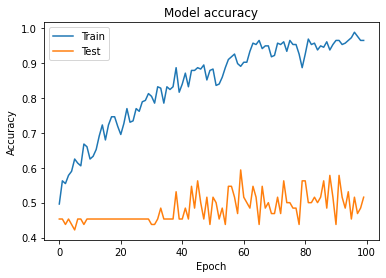

In [28]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()

In [29]:
y_pred = model.predict(x_test)

In [30]:
y_pred.shape[0]

80

In [31]:
y_pred[2][0]

0.05359051

In [32]:
def get_accuracy(y_pred, y_test):
  total_correct = 0.0
  for i in range(y_pred.shape[0]):
    if (np.round(y_pred[i]) == y_test[i]):
      total_correct += 1.0
  return total_correct / y_pred.shape[0]

In [33]:
get_accuracy(y_pred, y_test)

0.7125